# Shot Detection Using a Color Histogram

Based on the approach in [Zhang, 1993](https://dl.acm.org/citation.cfm?id=173858). Tested on the pilot episode of [Serial Experiments Lain](https://en.wikipedia.org/wiki/Serial_Experiments_Lain).

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_style("darkgrid")

In [3]:
def capture_handle(filename):
    """
    Get a handle to a source of frames
    """
    cap = cv2.VideoCapture()
    cap.open(filename)
    return cap

In [25]:
def encode_pixel_vec(px_vec):
    """
    Compute 6-bit color code using 2 MSB from each color channel
    """
    return np.bitwise_or.reduce((px_vec & 192) >> [2,4,6], 1)

In [5]:
def color_histogram(frame):
    """
    Compute histogram over encoded pixels from frame
    """
    hist, _ = np.histogram(encode_pixel_vec(frame.reshape(1,-1,3).squeeze()), bins=range(0,64))
    return hist

In [6]:
def difference_sequence(cap, num_frames=1440):
    """
    Compute the difference between the color histogram of successive frames
    """
    histograms = []
    
    for i in range(num_frames):
        ret, frame = cap.read()
        if ret == False:
            break
        histograms.append(color_histogram(frame))
    return np.sum(np.fabs(np.diff(np.transpose(np.array(histograms)), axis=1)), axis=0)

In [7]:
cap = capture_handle('Serial_Experiments_Lain_01.mkv')
seq = difference_sequence(cap)

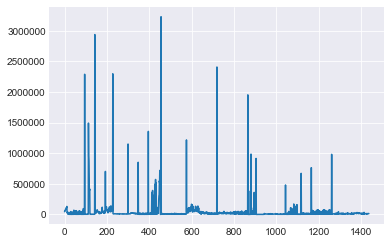

In [8]:
_ = plt.plot(seq)

/Users/rcj/.local/share/virtualenvs/video-segmentation-O3ARQPtg/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


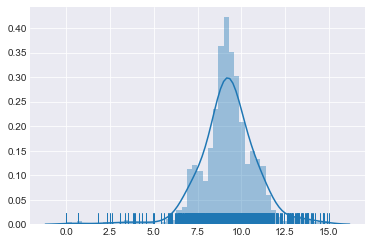

In [9]:
log_seq = np.ma.log(seq).filled(0)
_ = sns.distplot(log_seq, rug=True, kde=True, kde_kws={'bw': 0.4})

In [10]:
def threshold(seq, alpha):
    """
    Compute the threshold histogram value for a cut
    """
    return np.mean(seq) + alpha * np.std(seq)

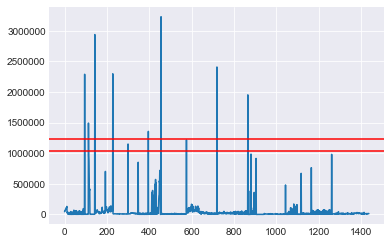

In [11]:
plt.plot(seq)
plt.axhline(threshold(seq, 5), color='r')
_ = plt.axhline(threshold(seq, 6), color='r')

In [29]:
# XXX: 5 seems fine
cut_threshold = threshold(seq, 5)
cut_frames = np.argwhere(seq > cut_threshold)

In [28]:
def get_frames(cap, frame_indices, num_frames=1440):
    """
    Given a list of frame indices, return the raw frames
    Assumes sorted(frame_indices)
    """
    frames = []
    max_frame_index = max(frame_indices)
    
    for i in range(num_frames):
        if i > max_frame_index:
            break
        ret, frame = cap.read()
        if ret == False:
            break
        if i in frame_indices:
            frames.append(frame)
            
    return frames

In [21]:
cap = capture_handle('Serial_Experiments_Lain_01.mkv')
boundary_frame_indices = (cut_frames + [0,1]).ravel()
frames = get_frames(cap, boundary_frame_indices)

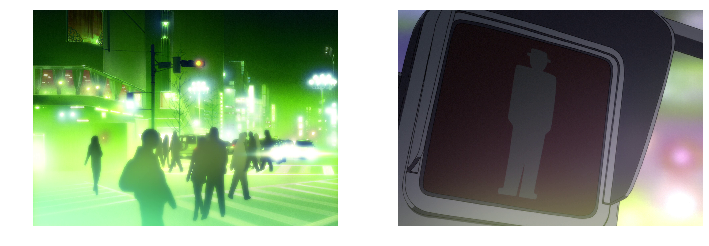

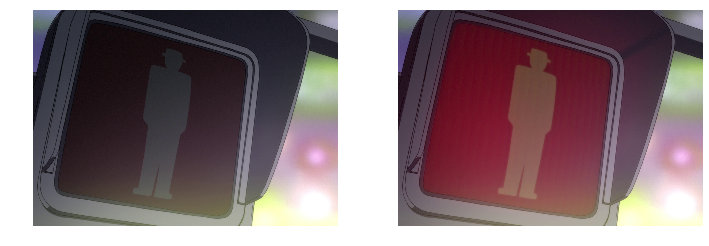

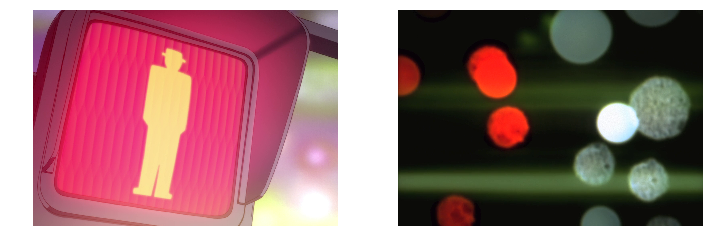

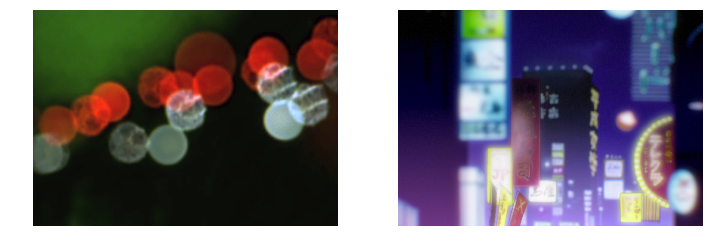

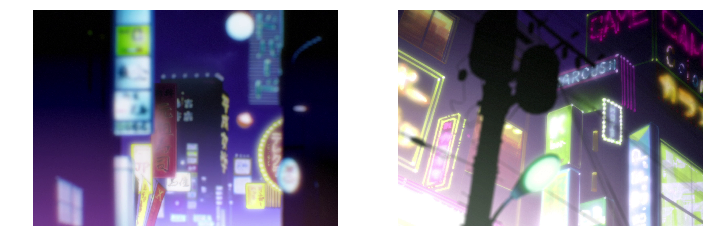

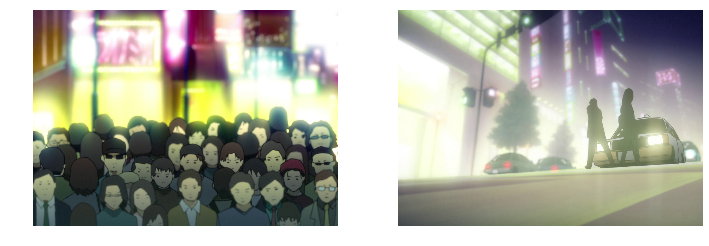

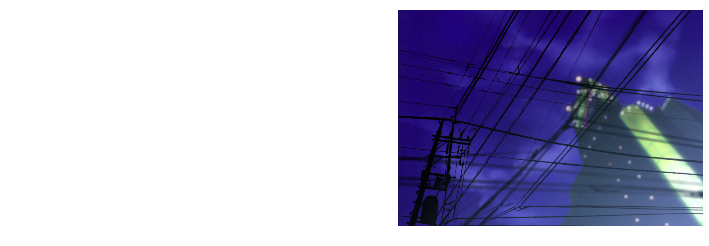

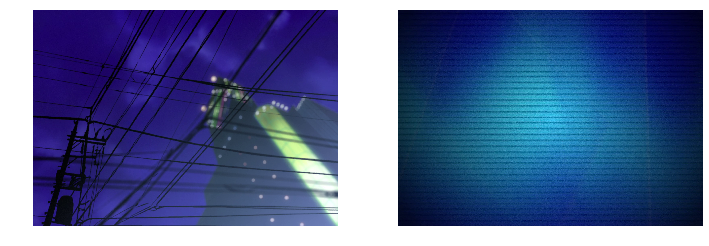

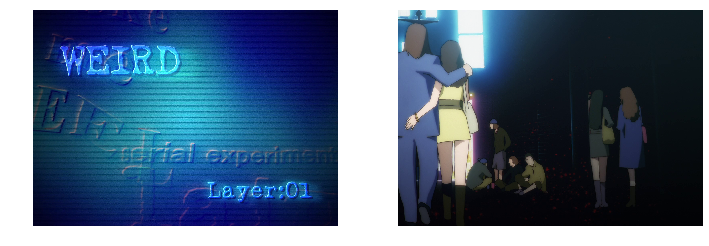

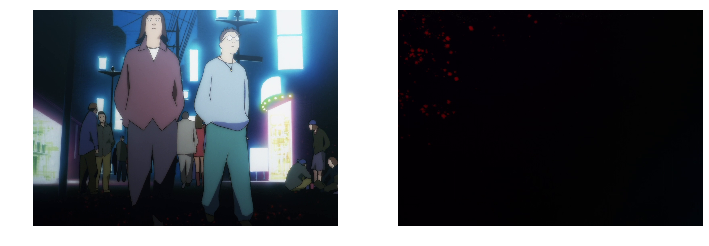

In [26]:
for i, frame in enumerate(frames):
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    if i % 2 == 0:
        fig = plt.figure(figsize=(12,24))
        plt.subplot(1, 2, 1)
    else:
        plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.axis('off')